<a href="https://colab.research.google.com/github/Hemanthtak2000/22073706_Project_UoH/blob/main/22073706_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title : Predictive Modeling for Vehicle Insurance to Optimize Customer Engagement

The project focuses on predictive modeling to identify customers who are more likely to purchase vehicle insurance, using data from those who have already bought health insurance from the same company. Addressing the class imbalance in the target variable (`Response`), the code includes preprocessing such as encoding categorical variables, removing outliers, scaling numerical features, and applying SMOTE for balancing the data. Several machine learning models, including Logistic Regression, Decision Tree, Random Forest, and Gaussian Naive Bayes, are trained and evaluated using metrics like Accuracy, ROC-AUC, and F1 scores. By implementing robust preprocessing, handling imbalance, and assessing model performance, the project aims to enhance customer targeting and engagement strategies.

In [ ]:
# Importing the libraries needed for the code implementation
import pandas as pd
from scipy.stats import randint
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

### 1. Data Loading

This section loads the insurance data and performs initial checks for missing values and duplicates.

In [ ]:
# Read the data from csv file in Github
Ins_Details_path = 'https://raw.githubusercontent.com/Hemanthtak2000/22073706_Project_UoH/refs/heads/main/aug_train.csv'
Ins_Details = pd.read_csv(Ins_Details_path)
# Display the first 5 rows of the dataset
Ins_Details.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [ ]:
# Check for Null values
Ins_Details.isna().sum()

,0
id,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0


In [ ]:
# Checking the datatypes of each variable in the dataset
Ins_Details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382154 non-null  int64  
 3   Driving_License       382154 non-null  int64  
 4   Region_Code           382154 non-null  float64
 5   Previously_Insured    382154 non-null  int64  
 6   Vehicle_Age           382154 non-null  object 
 7   Vehicle_Damage        382154 non-null  object 
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  float64
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 35.0+ MB


### 2. Data Pre-Processing

###### Feature Identification

Categorical and numerical features are identified for transformation and scaling.

In [ ]:
# Identifying all numerical features and categorical features from the dataset
Ins_num_Feat = Ins_Details.select_dtypes(exclude=['object']).columns.tolist()
print('The numerical features in the Insurance Dataset are:')
print(Ins_num_Feat)
Ins_cat_Feat = Ins_Details.select_dtypes(include=['object']).columns.tolist()
print('\nThe Categorical features in the Insurance Dataset are:')
print(Ins_cat_Feat)

The numerical features in the Insurance Dataset are:
['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']

The Categorical features in the Insurance Dataset are:
['Gender', 'Vehicle_Age', 'Vehicle_Damage']


###### Label Encoding

Encoding categorical features to numeric values.

In [ ]:
# make an instance of Label Encoder
Labenc_Catfeat = LabelEncoder()

# transforming the Categorical variables into Numericals using Label Encoder
Ins_Details['Gender'] = Labenc_Catfeat.fit_transform(Ins_Details['Gender'])
Ins_Details['Vehicle_Age'] = Labenc_Catfeat.fit_transform(Ins_Details['Vehicle_Age'])
Ins_Details['Vehicle_Damage'] = Labenc_Catfeat.fit_transform(Ins_Details['Vehicle_Damage'])

###### Handling Duplicates

In [ ]:
# Checking for duplicates
Dup_Ins_Dtls = Ins_Details.duplicated()
# Display the number of duplicate rows
Total_Ins_Dup = Dup_Ins_Dtls.sum()
print(f'Number of duplicate rows: {Total_Ins_Dup}')

Number of duplicate rows: 0


In [ ]:
# Removing the Id columns as this is irrelavant
Ins_Details.drop(columns=['id'], inplace=True)

###### Outlier Detection and Removal

Outliers in Annual_Premium are handled using the IQR method.

In [ ]:
# Function for the detection of outliers
# referred the website for algorithm for detection and removal of outliers
#https://www.freecodecamp.org/news/how-to-detect-outliers-in-machine-learning/

def detect_outliers_iqr(data, column):
    """
    Detect outliers in a dataset using the Interquartile Range (IQR) method.

    Parameters:
    data (DataFrame): The input pandas DataFrame containing the data.
    column (str): The name of the column in which to detect outliers.

    Returns:
    DataFrame: A subset of the input DataFrame containing rows that are outliers
               based on the IQR method.
    """

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Check for outliers in the 'Annual_Premium' column
Out_Det_Ann_Pre = detect_outliers_iqr(Ins_Details, 'Annual_Premium')

# Display the number of outliers and the outlier rows
Ins_OL_Ins_AP = Out_Det_Ann_Pre.shape[0]
print(f'Number of outliers in Annual_Premium: {Ins_OL_Ins_AP}')
print(Out_Det_Ann_Pre)


Number of outliers in Annual_Premium: 10407
        Gender  Age  Driving_License  Region_Code  Previously_Insured  \
10           1   25                1          8.0                   1   
45           0   58                1         28.0                   0   
49           1   22                1          8.0                   0   
50           0   48                1         28.0                   0   
101          0   65                1         28.0                   1   
...        ...  ...              ...          ...                 ...   
382075       1   47                1         28.0                   0   
382089       0   66                1         28.0                   0   
382106       0   46                1          8.0                   0   
382120       0   48                1          8.0                   1   
382150       1   27                1         28.0                   1   

        Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
10

In [ ]:
# Calculate the IQR bounds
Q1 = Ins_Details['Annual_Premium'].quantile(0.25)
Q3 = Ins_Details['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to keep only values within the bounds
Ins_Details_PP_OL = Ins_Details[(Ins_Details['Annual_Premium'] >= lower_bound) & (Ins_Details['Annual_Premium'] <= upper_bound)]

# Display the new DataFrame shape after outlier removal
print(f'Original DataFrame shape: {Ins_Details.shape}')
print(f'DataFrame shape after outlier removal: {Ins_Details_PP_OL.shape}')


Original DataFrame shape: (382154, 11)
DataFrame shape after outlier removal: (371747, 11)


###### Scaling

In [ ]:
# Initialize a StandardScaler
Scaler_InsData = StandardScaler()
# Apply the scaler to the 'Annual_Premium' column
Ins_Details_PP_OL.loc[:, ['Annual_Premium']] = Scaler_InsData.fit_transform(Ins_Details_PP_OL[['Annual_Premium']])

In [ ]:
# Checking the Dataset info after pre-processing
Ins_Details_PP_OL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 371747 entries, 0 to 382153
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                371747 non-null  int64  
 1   Age                   371747 non-null  int64  
 2   Driving_License       371747 non-null  int64  
 3   Region_Code           371747 non-null  float64
 4   Previously_Insured    371747 non-null  int64  
 5   Vehicle_Age           371747 non-null  int64  
 6   Vehicle_Damage        371747 non-null  int64  
 7   Annual_Premium        371747 non-null  float64
 8   Policy_Sales_Channel  371747 non-null  float64
 9   Vintage               371747 non-null  int64  
 10  Response              371747 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 34.0 MB


In [ ]:
# Printing the first 5 rows of the data after pre-processing
Ins_Details_PP_OL.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,22,1,7.0,1,1,0,-1.83,152.0,16,0
1,1,42,1,28.0,0,0,1,0.95,26.0,135,0
2,0,66,1,33.0,0,0,1,0.44,124.0,253,0
3,0,22,1,33.0,0,1,0,-0.12,152.0,69,0
4,1,28,1,46.0,1,1,0,-0.03,152.0,211,0


### 3. Exploratory Data Analysis (EDA)

Visualizing distributions and correlations between features.

###### Class Imbalance Visualization

In [ ]:
# Printing to See unique values in the response and its count
Cnt_Class_Ins = Ins_Details_PP_OL['Response'].value_counts()
print(Cnt_Class_Ins)

Response
0    311222
1     60525
Name: count, dtype: int64


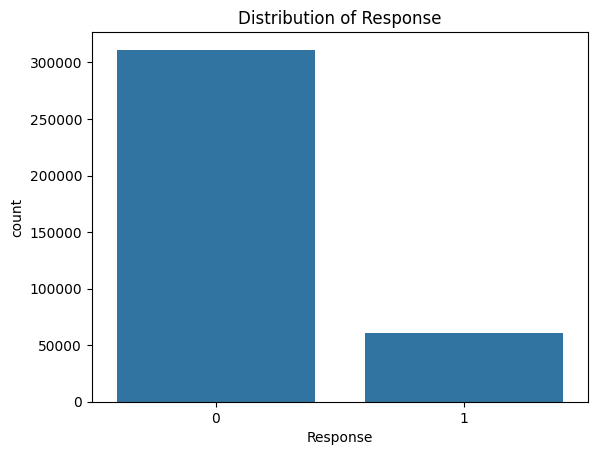

In [ ]:
# Visualize the Response variable Distribution
sns.countplot(x='Response', data=Ins_Details_PP_OL)
# Adding the title to the plot
plt.title('Distribution of Response')
# Display the plot
plt.show()

###### Annual Premium destribution and Outliers Visualization

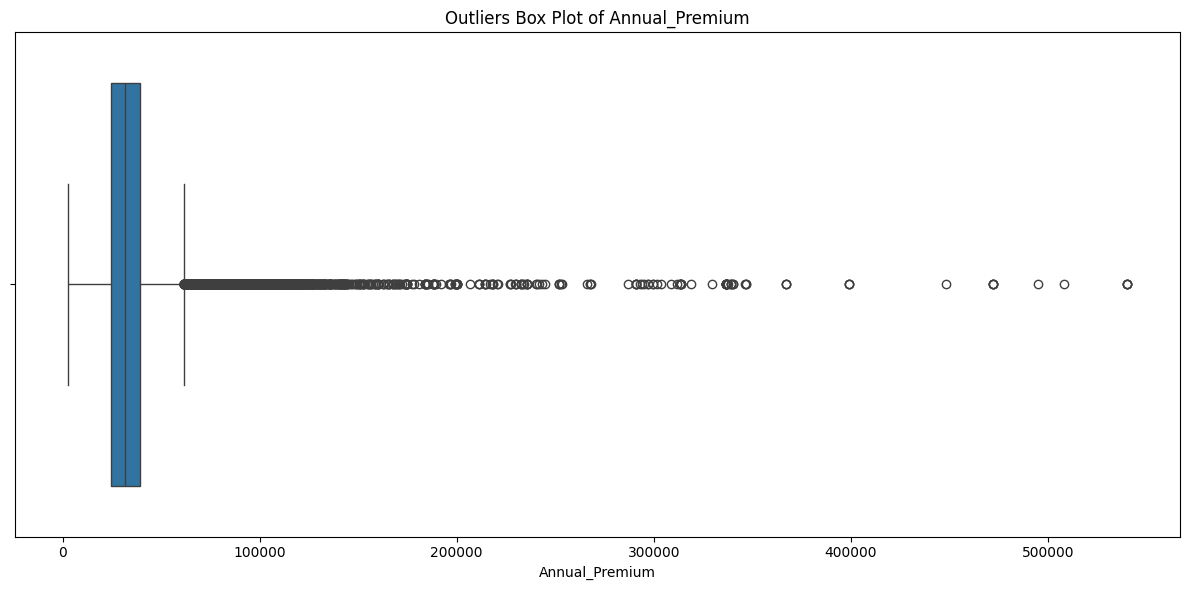

In [ ]:
# Annual premium beox plot before scaling and outlier removal
plt.figure(figsize=(12, 6))
sns.boxplot(x=Ins_Details['Annual_Premium'])
#Add plot titles and display the plot
plt.title('Outliers Box Plot of Annual_Premium')
plt.tight_layout()
plt.show()

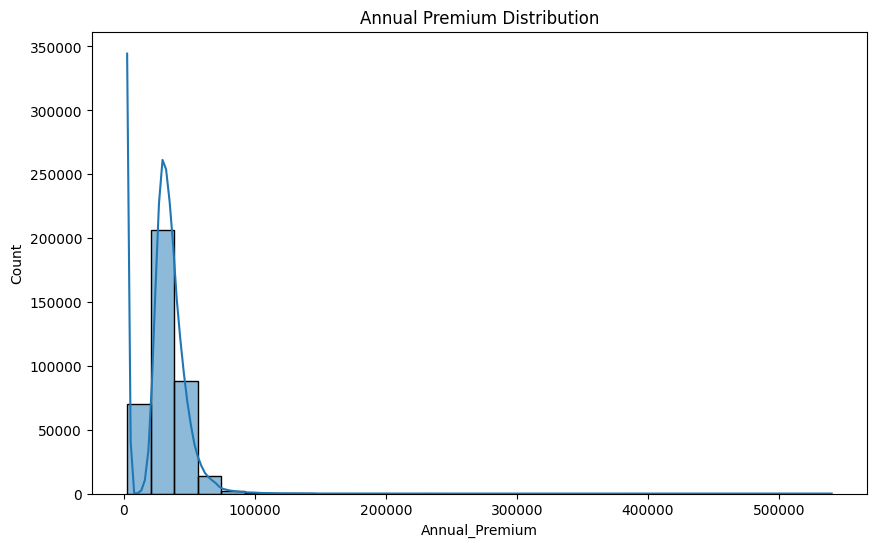

In [ ]:
# Annual Premium Distribution before Outliers removal and scaling
plt.figure(figsize=(10, 6))
sns.histplot(Ins_Details['Annual_Premium'], kde=True, bins=30)
#Set plot title and display the plot
plt.title('Annual Premium Distribution')
plt.show()

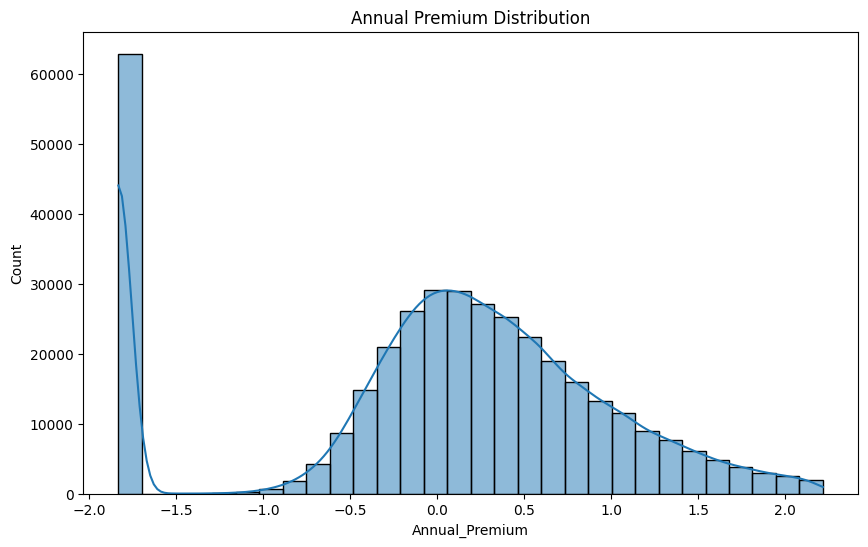

In [ ]:
# Annual Premium Distribution after Outliers removal and scaling
plt.figure(figsize=(10, 6))
sns.histplot(Ins_Details_PP_OL['Annual_Premium'], kde=True, bins=30)
# Set the plot title and display the plot
plt.title('Annual Premium Distribution')
plt.show()

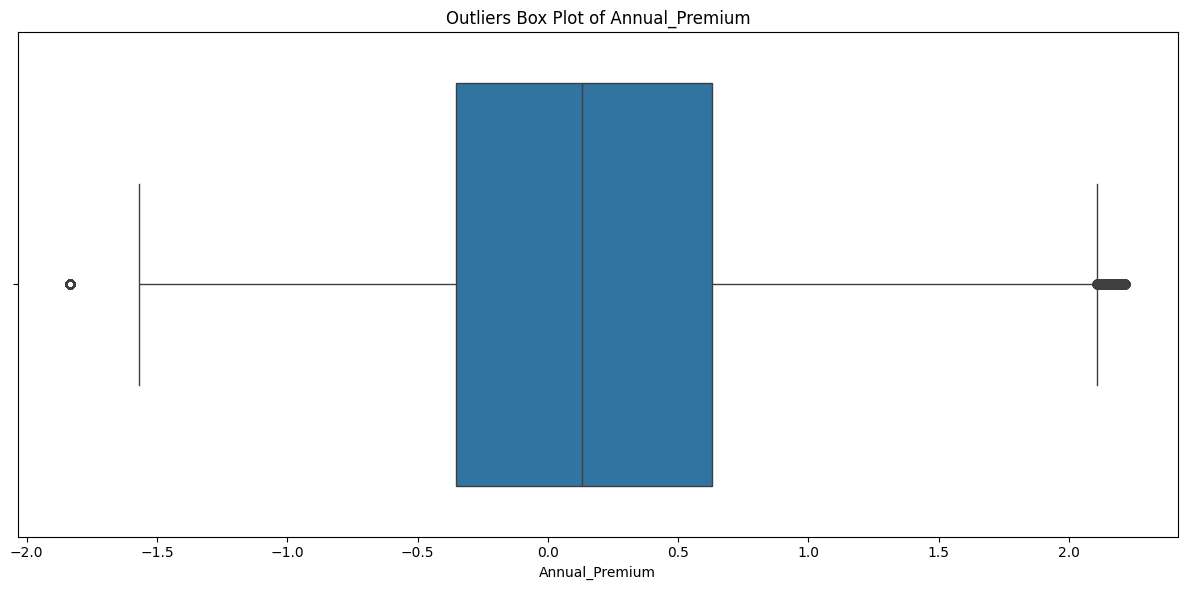

In [ ]:
# Box plot for Annual premium after outlier removal
plt.figure(figsize=(12, 6))
sns.boxplot(x=Ins_Details_PP_OL['Annual_Premium'])
# Set the plot title and display the plot
plt.title('Outliers Box Plot of Annual_Premium')
plt.tight_layout()
plt.show()


###### Correlation Analysis

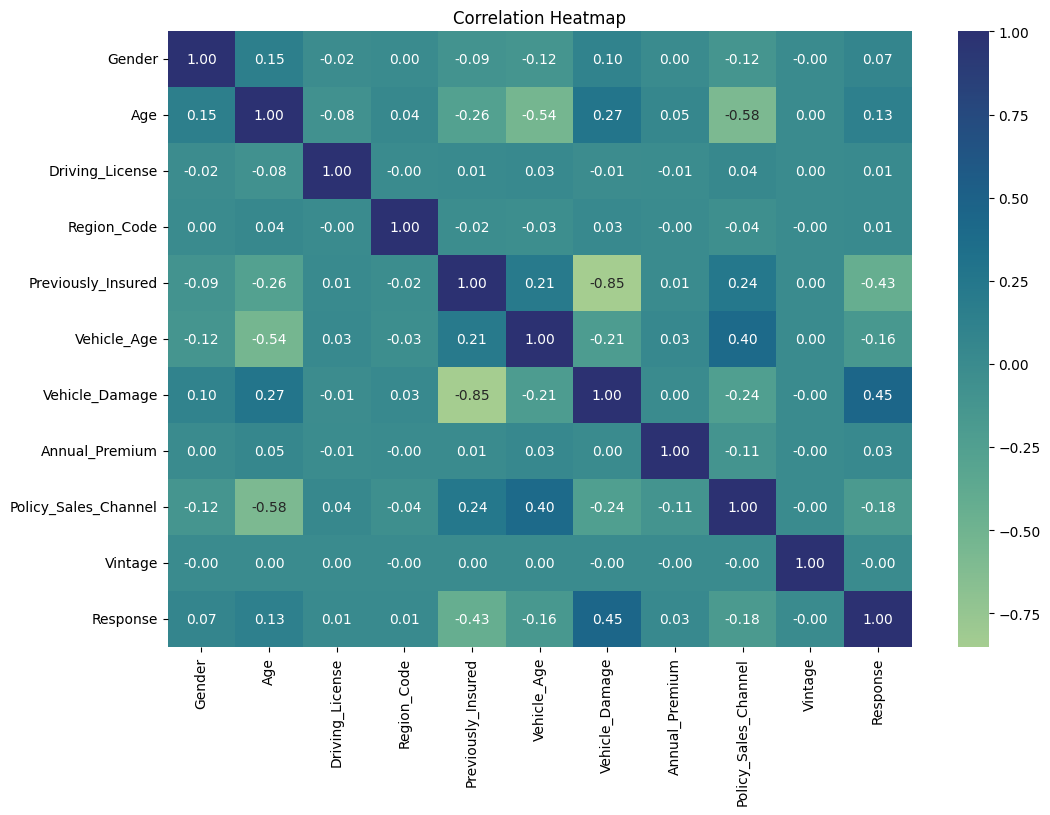

In [ ]:
# Calculate the correlation matrix using the dataset
CorMat_Ins = Ins_Details_PP_OL.corr()
# Create a figure
plt.figure(figsize=(12, 8))
#Producing heatmap using the correlation matrix
sns.heatmap(CorMat_Ins, annot=True, cmap='crest', fmt=".2f")
#Set the title
plt.title('Correlation Heatmap')
# Display the plot
plt.show()


###### Distribution Plots

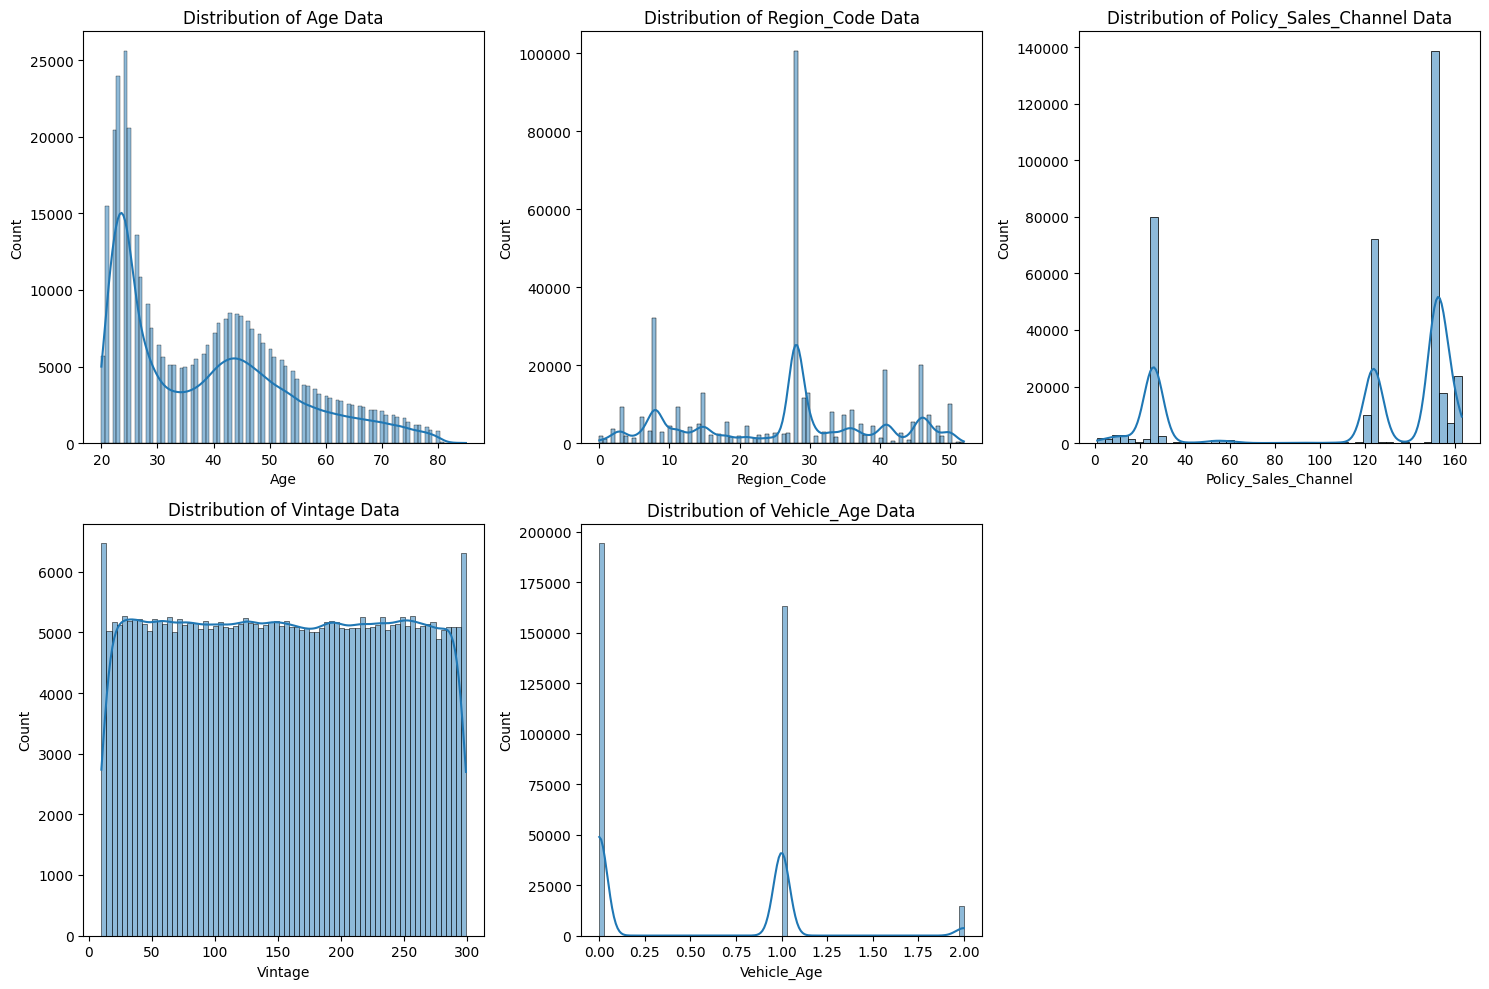

In [ ]:
# code for distribution plots
col_list = ['Age', 'Region_Code', 'Policy_Sales_Channel',
            'Vintage','Vehicle_Age']
# Create figure and histograms
plt.figure(figsize=(15,10))
for i,col in enumerate(col_list,1):
    plt.subplot(2,3,i)
    #Set plot titles
    plt.title(f"Distribution of {col} Data")
    #Plot histogram for each plot
    sns.histplot(Ins_Details_PP_OL[col],kde=True)
    plt.tight_layout()
    plt.plot()

### 3. Models Implementation

In [ ]:
# Initialize lists to store model names and their evaluation metrics
Models_Ch_Ins = []
Acc_Val_Ins = []
roc_auc_Val_Ins = []
f1_score_val_Ins = []

def Evaluate_Models_Ins(model_name, test_result, pred_result, proba_val):
    """
    Record and display evaluation metrics for a given model.

    This function computes and displays a confusion matrix, classification report,
    and key evaluation metrics accuracy, ROC AUC, F1 score for a model. It also
    plots the ROC curve and stores the results for comparison.

    Parameters:
    model_name (str): Name of the model being evaluated.
    test_result (array-like): True labels of the test dataset.
    pred_result (array-like): Predicted labels by the model.
    proba_val (array-like): Predicted probabilities for the positive class.
    """
    # Calculate and display the confusion matrix
    print(f'\nConfusion Matrix for {model_name}\n')
    confmat_Models = confusion_matrix(test_result, pred_result)
    print(confmat_Models)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(confmat_Models, annot=True, fmt='d', cmap='Blues', cbar=True, square=True,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix Heatmap for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    # Display the classification report
    print(f'\nClassification Report for {model_name}\n\n')
    print(classification_report(test_result, pred_result))

    # Compute evaluation metrics
    x_acc_score = accuracy_score(test_result, pred_result)
    x_roc_acu = roc_auc_score(test_result, pred_result)
    x_f1_score = f1_score(test_result, pred_result)

    # Print the evaluation metrics
    print(f'\n\nResults for {model_name}\n\n')
    print(f'Accuracy is: {x_acc_score:.2f}')
    print(f'ROC AUC is : {x_roc_acu:.2f}')
    print(f'F1 Score is : {x_f1_score:.2f}')

    # Append metrics to the respective lists
    Models_Ch_Ins.append(model_name)
    Acc_Val_Ins.append(x_acc_score)
    roc_auc_Val_Ins.append(x_roc_acu)
    f1_score_val_Ins.append(x_f1_score)

    # Plot the ROC curve
    print(f'\nROC Curve for {model_name}\n\n')
    fpr, tpr, threshold = roc_curve(test_result, proba_val)
    plt.figure()
    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % x_roc_acu)
    plt.plot([0, 1], [0, 1], 'k--')
    # Set the Limits for X and Y axis
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    # Set the Labels for X and Y axis
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    # Set the plot title and display the plot
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}\n')
    plt.legend(loc="lower right")
    plt.show()


#### Data Splitting

In [ ]:
# Separate the Predictors and the target variable
Ins_Pred_Col = Ins_Details_PP_OL.drop(['Response'], axis=1)
Ins_Tgt_Col = Ins_Details_PP_OL['Response']
# Split the dataset into training and testing sets
Ins_Pred_Trn, Ins_Pred_Test, Ins_Tgt_Trn, Ins_Tgt_Test = train_test_split(Ins_Pred_Col, Ins_Tgt_Col, test_size=0.2, random_state=3706)

Data OverSampling

In [ ]:
# Initialize SMOTE for oversampling
Ins_Smote_Over = SMOTE(random_state=3706)
# Apply SMOTE to oversample the minority class in the training data
Ins_Pred_Trn_Oversampled, Ins_Tgt_Trn_oversampled = Ins_Smote_Over.fit_resample(Ins_Pred_Trn, Ins_Tgt_Trn)

Data Undersampling

In [ ]:
# Apply RandomUnderSampler to the training data
Ins_Us_Under = RandomUnderSampler(random_state=3706)
Ins_Pred_Trn_undersampled, Ins_Tgt_Trn_undersampled = Ins_Us_Under.fit_resample(Ins_Pred_Trn, Ins_Tgt_Trn)

Sampling Visualization

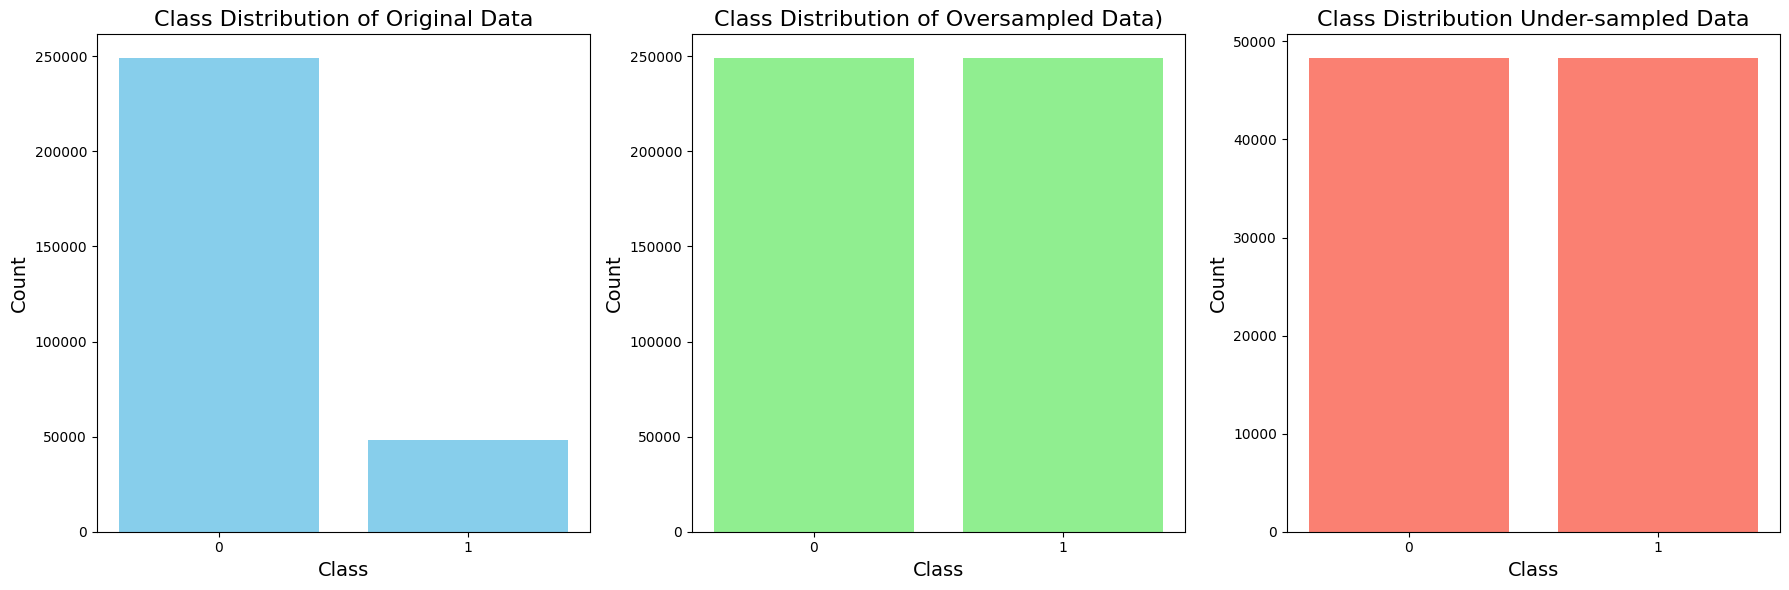

In [ ]:
# Count the class distribution for original, oversampled, and undersampled data
cnt_Before_smplng = Counter(Ins_Tgt_Trn)
cnt_after_Oversmp = Counter(Ins_Tgt_Trn_oversampled)
cnt_after_undrsmp = Counter(Ins_Tgt_Trn_undersampled)

# Convert counts to DataFrames for plotting
org_df_Ins = pd.DataFrame.from_dict(cnt_Before_smplng, orient='index', columns=['Count']).reset_index()
org_df_Ins.rename(columns={'index': 'Class'}, inplace=True)

Over_df_Ins = pd.DataFrame.from_dict(cnt_after_Oversmp, orient='index', columns=['Count']).reset_index()
Over_df_Ins.rename(columns={'index': 'Class'}, inplace=True)

Under_df_Ins = pd.DataFrame.from_dict(cnt_after_undrsmp, orient='index', columns=['Count']).reset_index()
Under_df_Ins.rename(columns={'index': 'Class'}, inplace=True)

# Plot the distributions
plt.figure(figsize=(18, 6))

# Original Data
plt.subplot(1, 3, 1)
plt.bar(org_df_Ins['Class'], org_df_Ins['Count'], color='skyblue')
# Set the plot title and labels for axis
plt.title('Class Distribution of Original Data',fontsize=16)
plt.xlabel('Class',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(ticks=org_df_Ins['Class'])

# Oversampled Data
plt.subplot(1, 3, 2)
plt.bar(Over_df_Ins['Class'], Over_df_Ins['Count'], color='lightgreen')
# Set the plot title and labels for axis
plt.title('Class Distribution of Oversampled Data)',fontsize=16)
plt.xlabel('Class',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(ticks=Over_df_Ins['Class'])

# Undersampled Data
plt.subplot(1, 3, 3)
plt.bar(Under_df_Ins['Class'], Under_df_Ins['Count'], color='salmon')
# Set the plot title and labels for axis
plt.title('Class Distribution Under-sampled Data',fontsize=16)
plt.xlabel('Class',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(ticks=Under_df_Ins['Class'])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


#### Training Logistic Regression

##### Training Logistic Regression on Original Data

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Confusion Matrix for Logistic Regression

[[62003   125]
 [12122   100]]


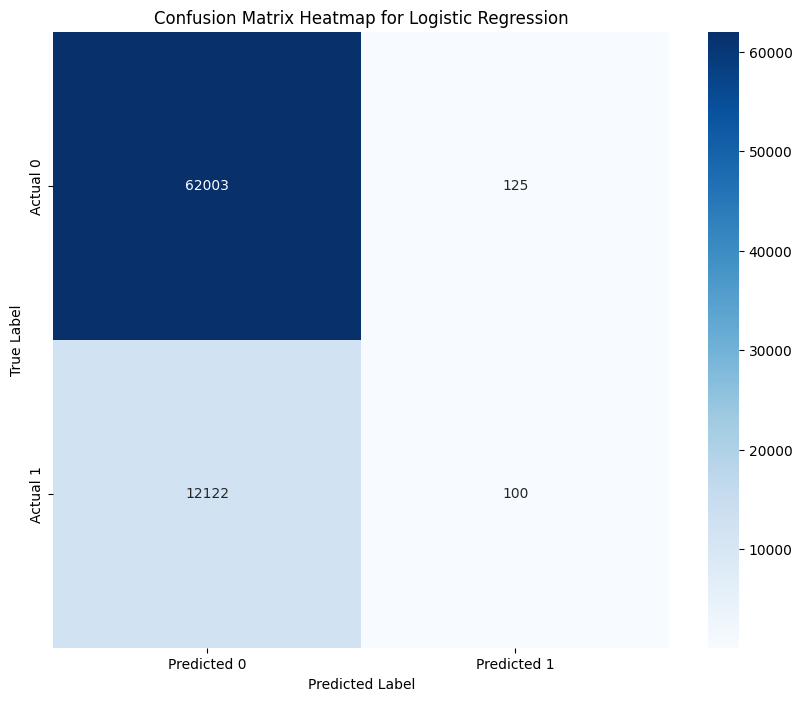


Classification Report for Logistic Regression


              precision    recall  f1-score   support

           0       0.84      1.00      0.91     62128
           1       0.44      0.01      0.02     12222

    accuracy                           0.84     74350
   macro avg       0.64      0.50      0.46     74350
weighted avg       0.77      0.84      0.76     74350



Results for Logistic Regression


Accuracy is: 0.84
ROC AUC is : 0.50
F1 Score is : 0.02

ROC Curve for Logistic Regression




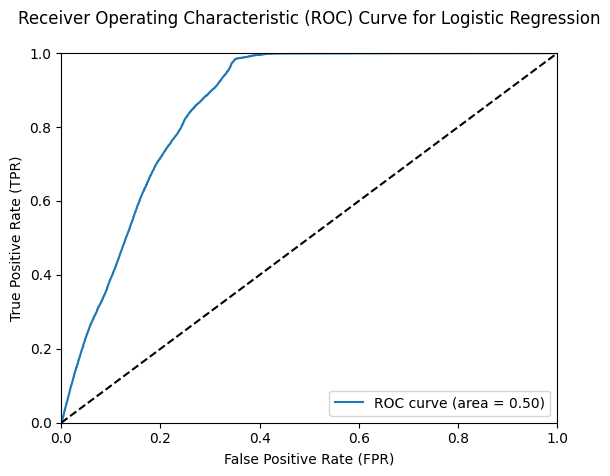

In [ ]:
# Declare the parameter grid for Logistic Regression
param_grid_LR = {
    'penalty': ['l2'],
    'C': [0.1],
    'solver': ['liblinear'],
    'max_iter': [500]
}

# Initiate the Logistic Regression model
Lr_Model_Int = LogisticRegression()

# Setup the RandomizedSearchCV for Logistic Regression Models
LRmodel_Tuned = RandomizedSearchCV(
    estimator=Lr_Model_Int,
    param_distributions=param_grid_LR,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=3706,
    n_jobs=-1
)

# Train the model on Original Dataset
LRmodel_Tuned.fit(Ins_Pred_Trn, Ins_Tgt_Trn)

# Get the best estimator for the model
best_LRModel = LRmodel_Tuned.best_estimator_

# Predict the results for the Test data
Ins_Tgt_pred = best_LRModel.predict(Ins_Pred_Test)

# Find the Prediction Probability of the Test data
Ins_Tgt_pred_proba = best_LRModel.predict_proba(Ins_Pred_Test)[:,1]

#Evaluate the model using the function
Evaluate_Models_Ins('Logistic Regression', Ins_Tgt_Test, Ins_Tgt_pred, Ins_Tgt_pred_proba)

##### Training Logistic Regression on Oversampled Data

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Confusion Matrix for Logistic Regression Over

[[41394 20734]
 [  878 11344]]


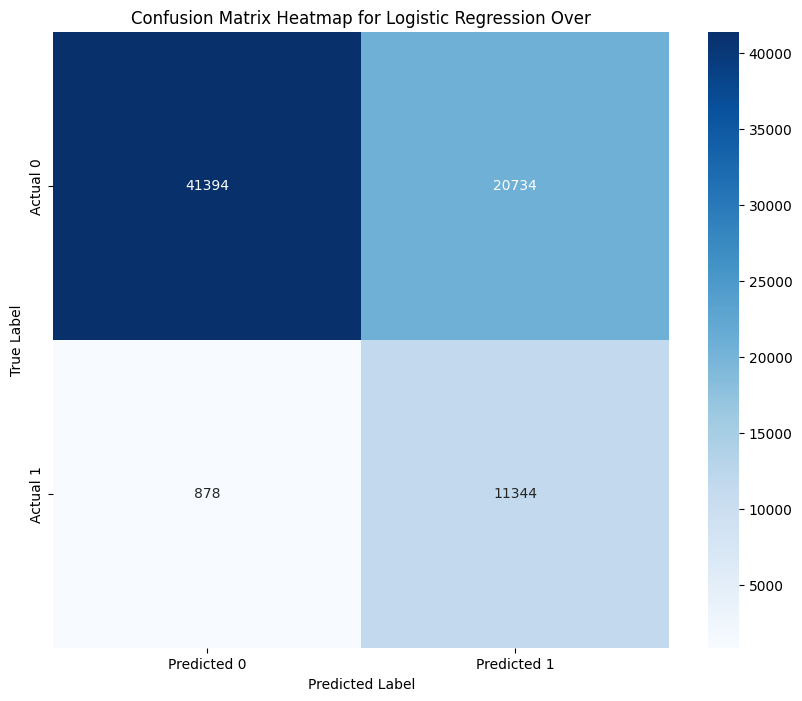


Classification Report for Logistic Regression Over


              precision    recall  f1-score   support

           0       0.98      0.67      0.79     62128
           1       0.35      0.93      0.51     12222

    accuracy                           0.71     74350
   macro avg       0.67      0.80      0.65     74350
weighted avg       0.88      0.71      0.75     74350



Results for Logistic Regression Over


Accuracy is: 0.71
ROC AUC is : 0.80
F1 Score is : 0.51

ROC Curve for Logistic Regression Over




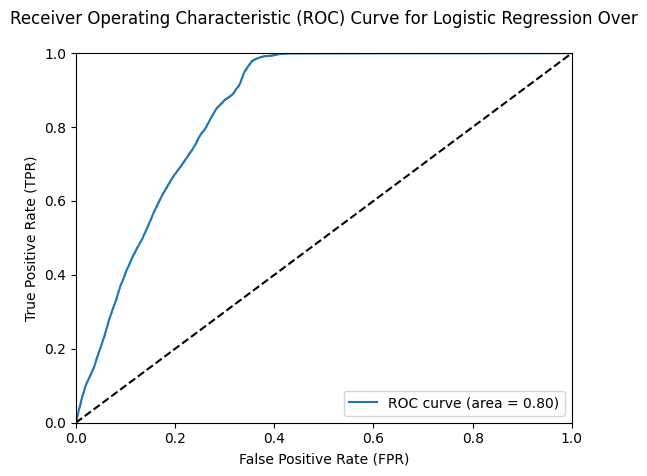

In [ ]:
# Train the model on oversampled Dataset
LRmodel_Tuned.fit(Ins_Pred_Trn_Oversampled, Ins_Tgt_Trn_oversampled)

# Get the best estimator
best_LRModel = LRmodel_Tuned.best_estimator_

# Predict the results for the Test data
Ins_Tgt_pred = best_LRModel.predict(Ins_Pred_Test)

# Find the Prediction Probability of the Test data
Ins_Tgt_pred_proba = best_LRModel.predict_proba(Ins_Pred_Test)[:,1]

#Evaluate the model using the function
Evaluate_Models_Ins('Logistic Regression Over', Ins_Tgt_Test, Ins_Tgt_pred, Ins_Tgt_pred_proba)

##### Training Logistic Regression on Undersampled Data

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Confusion Matrix for Logistic Regression Under

[[40247 21881]
 [  189 12033]]


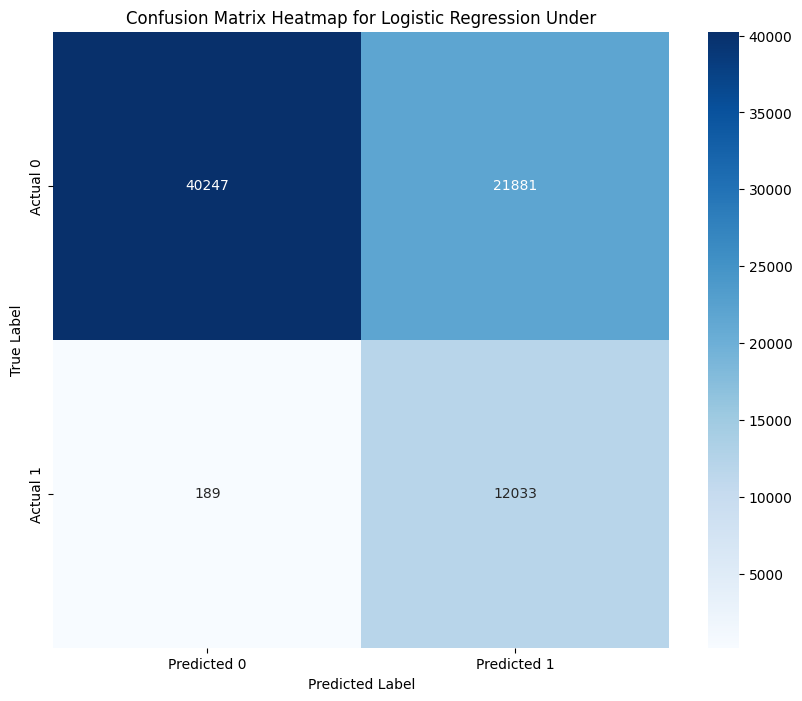


Classification Report for Logistic Regression Under


              precision    recall  f1-score   support

           0       1.00      0.65      0.78     62128
           1       0.35      0.98      0.52     12222

    accuracy                           0.70     74350
   macro avg       0.68      0.82      0.65     74350
weighted avg       0.89      0.70      0.74     74350



Results for Logistic Regression Under


Accuracy is: 0.70
ROC AUC is : 0.82
F1 Score is : 0.52

ROC Curve for Logistic Regression Under




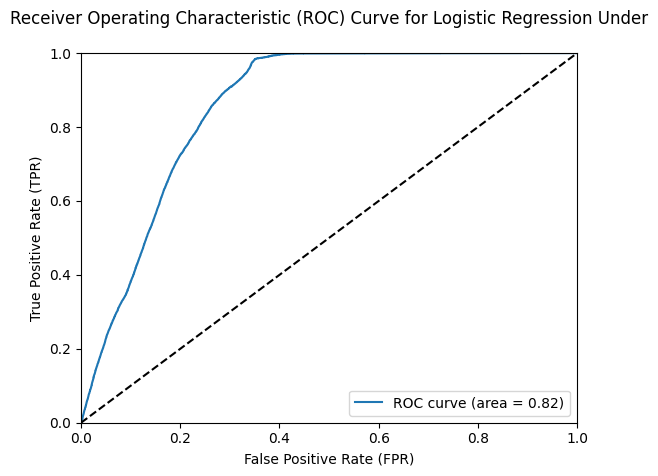

In [ ]:
# Train the model on Undersampled Dataset
LRmodel_Tuned.fit(Ins_Pred_Trn_undersampled, Ins_Tgt_Trn_undersampled)

# Get the best estimator
best_LRModel = LRmodel_Tuned.best_estimator_

# Predict the results for the Test data
Ins_Tgt_pred = best_LRModel.predict(Ins_Pred_Test)

# Find the Prediction Probability of the Test data
Ins_Tgt_pred_proba = best_LRModel.predict_proba(Ins_Pred_Test)[:,1]

#Evaluate the model using the function
Evaluate_Models_Ins('Logistic Regression Under', Ins_Tgt_Test, Ins_Tgt_pred, Ins_Tgt_pred_proba)

#### Training Decision Tree

##### Training Decision Tree on Original Data

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Confusion Matrix for Decision Tree Classifier

[[57961  4167]
 [ 7459  4763]]


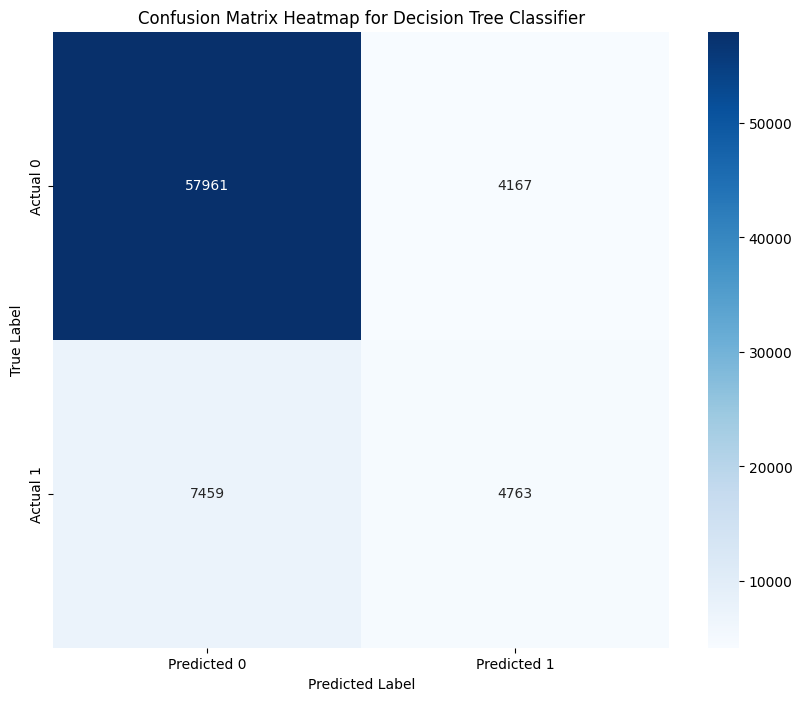


Classification Report for Decision Tree Classifier


              precision    recall  f1-score   support

           0       0.89      0.93      0.91     62128
           1       0.53      0.39      0.45     12222

    accuracy                           0.84     74350
   macro avg       0.71      0.66      0.68     74350
weighted avg       0.83      0.84      0.83     74350



Results for Decision Tree Classifier


Accuracy is: 0.84
ROC AUC is : 0.66
F1 Score is : 0.45

ROC Curve for Decision Tree Classifier




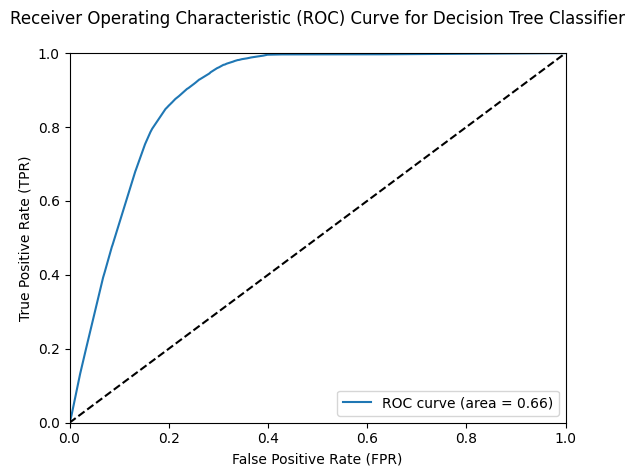

In [ ]:
# Initialize the decision tree Hyperparameters
param_grid_Dec = {
    'criterion': ['entropy'],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [20],
    'random_state': [3706]
}

# Tune the Decision Tree with Hyperparameters
Dectree_Tuned = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions=param_grid_Dec,
    n_iter=50,
    cv=3,
    verbose=1,
    random_state=3706,
    n_jobs=-1
)

# Train and Fit the Decision Tree on Original Data
Dectree_Tuned.fit(Ins_Pred_Trn, Ins_Tgt_Trn)

# Get the best estimator of Decision Tree
best_model_Dectree = Dectree_Tuned.best_estimator_

# Predict the results for the Test data
Ins_Tgt_pred = best_model_Dectree.predict(Ins_Pred_Test)

# Find the Prediction Probability of the Test data
Ins_Tgt_pred_proba = best_model_Dectree.predict_proba(Ins_Pred_Test)[:,1]

# Evaluate the model using function
Evaluate_Models_Ins('Decision Tree Classifier', Ins_Tgt_Test, Ins_Tgt_pred, Ins_Tgt_pred_proba)

#####  Training Decision Tree on Oversampled Data

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Confusion Matrix for Decision Tree Classifier Over

[[48203 13925]
 [ 1534 10688]]


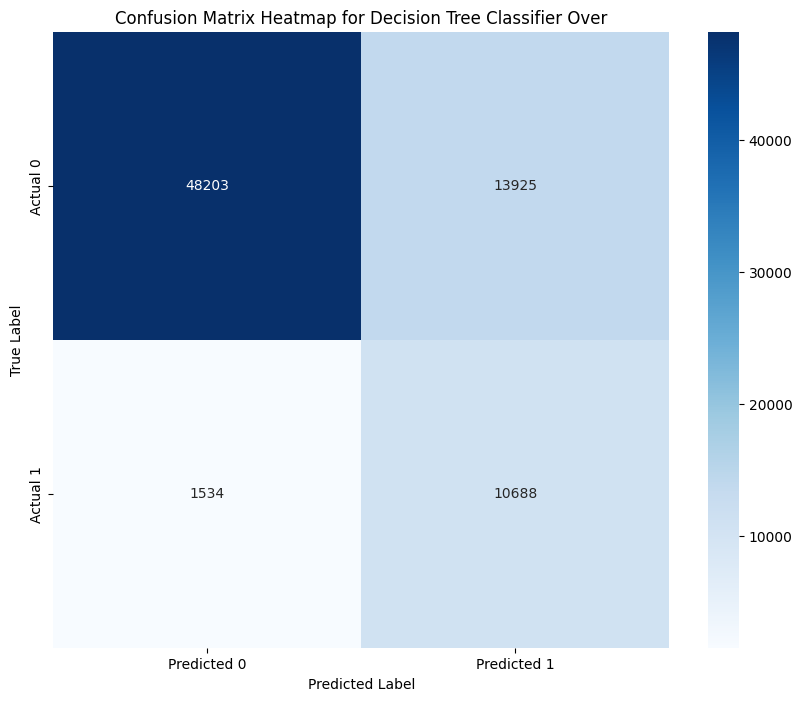


Classification Report for Decision Tree Classifier Over


              precision    recall  f1-score   support

           0       0.97      0.78      0.86     62128
           1       0.43      0.87      0.58     12222

    accuracy                           0.79     74350
   macro avg       0.70      0.83      0.72     74350
weighted avg       0.88      0.79      0.82     74350



Results for Decision Tree Classifier Over


Accuracy is: 0.79
ROC AUC is : 0.83
F1 Score is : 0.58

ROC Curve for Decision Tree Classifier Over




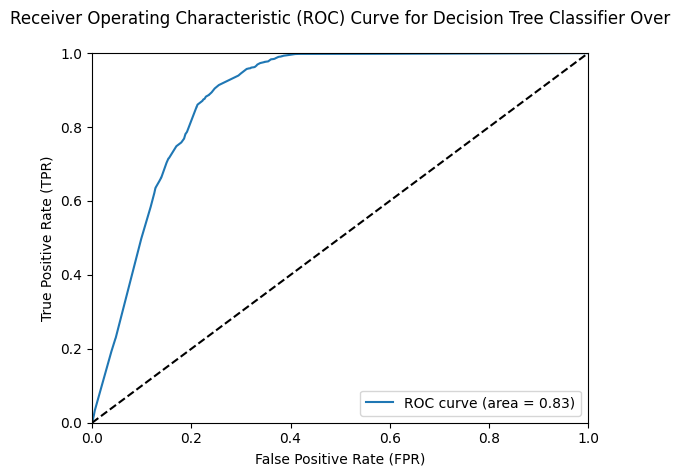

In [ ]:
# Train and Fit the model on Oversampled Data
Dectree_Tuned.fit(Ins_Pred_Trn_Oversampled, Ins_Tgt_Trn_oversampled)

# Get the best estimator
best_model_Dectree = Dectree_Tuned.best_estimator_

# Predict the results for the Test data
Ins_Tgt_pred = best_model_Dectree.predict(Ins_Pred_Test)

# Find the Prediction Probability of the Test data
Ins_Tgt_pred_proba = best_model_Dectree.predict_proba(Ins_Pred_Test)[:,1]

# Evaluate the model using function
Evaluate_Models_Ins('Decision Tree Classifier Over', Ins_Tgt_Test, Ins_Tgt_pred, Ins_Tgt_pred_proba)

#####  Training Decision Tree on Undersampled Data

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Confusion Matrix for Decision Tree Classifier Under

[[46928 15200]
 [ 1094 11128]]


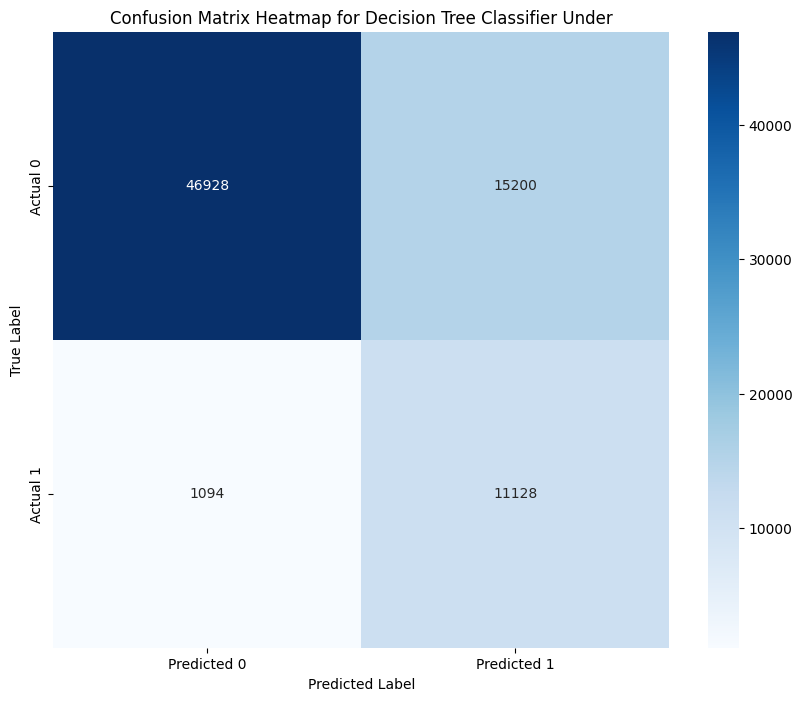


Classification Report for Decision Tree Classifier Under


              precision    recall  f1-score   support

           0       0.98      0.76      0.85     62128
           1       0.42      0.91      0.58     12222

    accuracy                           0.78     74350
   macro avg       0.70      0.83      0.71     74350
weighted avg       0.89      0.78      0.81     74350



Results for Decision Tree Classifier Under


Accuracy is: 0.78
ROC AUC is : 0.83
F1 Score is : 0.58

ROC Curve for Decision Tree Classifier Under




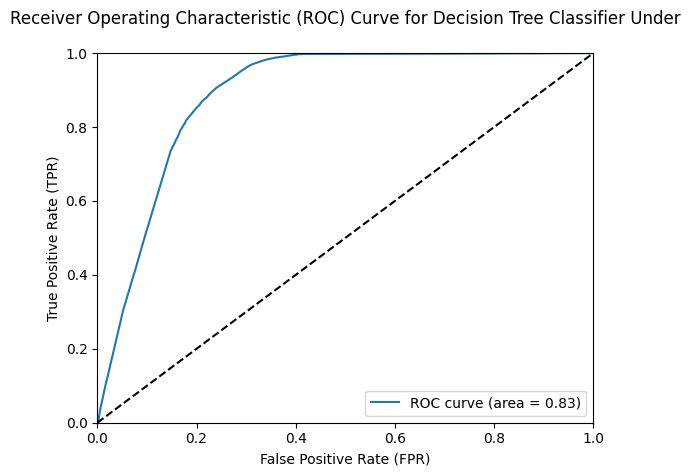

In [ ]:
# Train and Fit the model on Undersampled data
Dectree_Tuned.fit(Ins_Pred_Trn_undersampled, Ins_Tgt_Trn_undersampled)

# Get the best estimator
best_model_Dectree = Dectree_Tuned.best_estimator_

# Predict the results for the Test data
Ins_Tgt_pred = best_model_Dectree.predict(Ins_Pred_Test)

# Find the Prediction Probability of the Test data
Ins_Tgt_pred_proba = best_model_Dectree.predict_proba(Ins_Pred_Test)[:,1]

# Evaluate the model using function
Evaluate_Models_Ins('Decision Tree Classifier Under', Ins_Tgt_Test, Ins_Tgt_pred, Ins_Tgt_pred_proba)

#### Training Random Forest Classifier

##### Training Random Forest Classifier on Original Data

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Confusion Matrix for Random Forest Classifier

[[61635   493]
 [11512   710]]


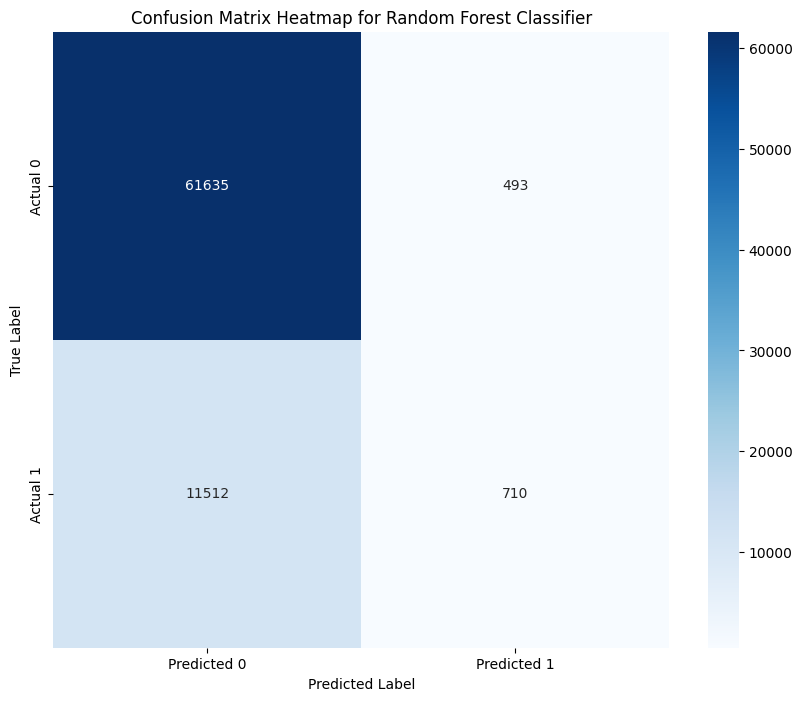


Classification Report for Random Forest Classifier


              precision    recall  f1-score   support

           0       0.84      0.99      0.91     62128
           1       0.59      0.06      0.11     12222

    accuracy                           0.84     74350
   macro avg       0.72      0.53      0.51     74350
weighted avg       0.80      0.84      0.78     74350



Results for Random Forest Classifier


Accuracy is: 0.84
ROC AUC is : 0.53
F1 Score is : 0.11

ROC Curve for Random Forest Classifier




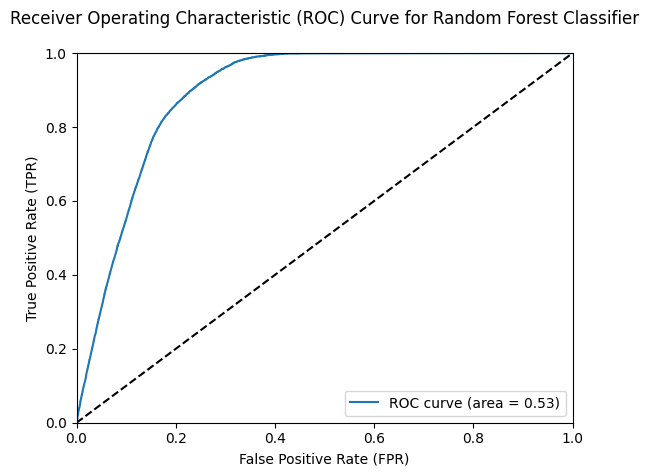

In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [4],
}
Ranfor_Int = RandomForestClassifier()
# Setup the RandomizedSearchCV
Ranfor_Tuned = RandomizedSearchCV(
    estimator=Ranfor_Int,
    param_distributions=param_grid_rf,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=3706,
    n_jobs=-1
)

# Train and Fit the model on Original data
Ranfor_Tuned.fit(Ins_Pred_Trn, Ins_Tgt_Trn)

# Get the best estimator
best_model_Ranfor = Ranfor_Tuned.best_estimator_

# Predict the results for the Test data
Ins_Tgt_pred = best_model_Ranfor.predict(Ins_Pred_Test)

# Find the Prediction Probability of the Test data
Ins_Tgt_pred_proba = best_model_Ranfor.predict_proba(Ins_Pred_Test)[:,1]

#Evaluate The models using the function
Evaluate_Models_Ins('Random Forest Classifier', Ins_Tgt_Test, Ins_Tgt_pred, Ins_Tgt_pred_proba)

##### Training Random Forest Classifier on Oversampled Data

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Confusion Matrix for Random Forest Classifier Over 

[[47700 14428]
 [ 1316 10906]]


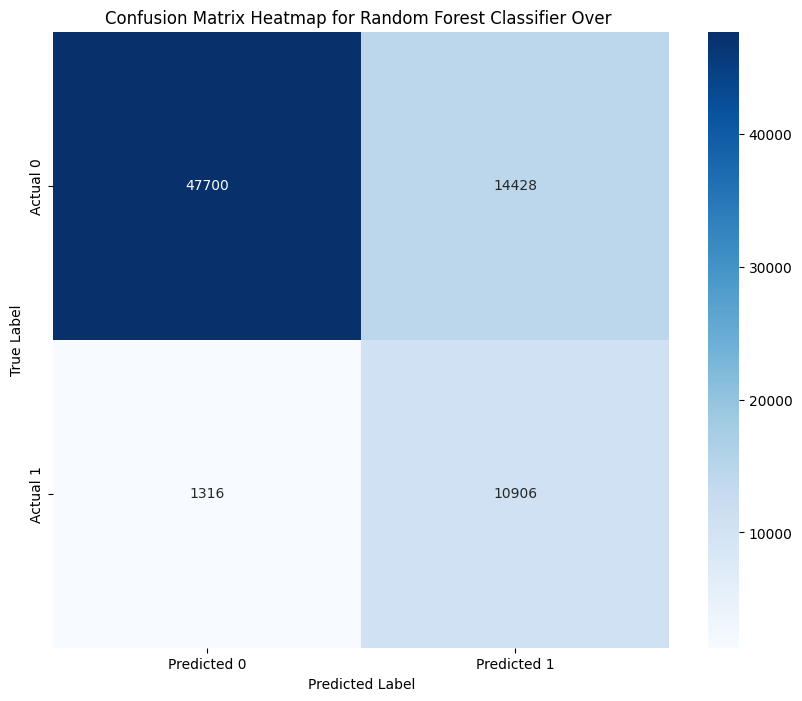


Classification Report for Random Forest Classifier Over 


              precision    recall  f1-score   support

           0       0.97      0.77      0.86     62128
           1       0.43      0.89      0.58     12222

    accuracy                           0.79     74350
   macro avg       0.70      0.83      0.72     74350
weighted avg       0.88      0.79      0.81     74350



Results for Random Forest Classifier Over 


Accuracy is: 0.79
ROC AUC is : 0.83
F1 Score is : 0.58

ROC Curve for Random Forest Classifier Over 




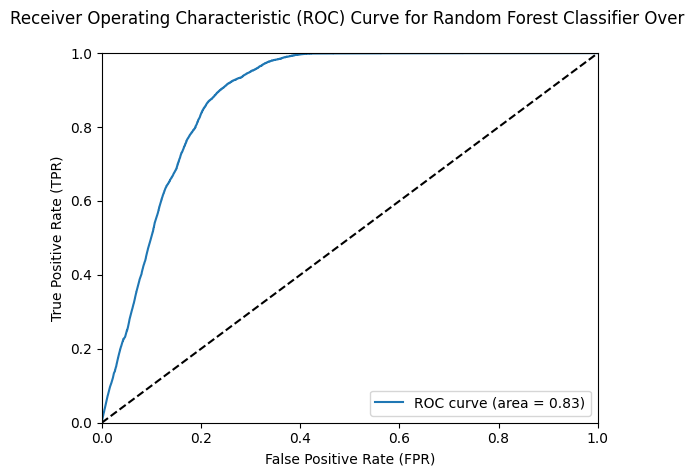

In [ ]:
# Train and Fit the model on Oversampled data
Ranfor_Tuned.fit(Ins_Pred_Trn_Oversampled, Ins_Tgt_Trn_oversampled)

# Get the best estimator
best_model_Ranfor = Ranfor_Tuned.best_estimator_

# Predict the results for the Test data
Ins_Tgt_pred = best_model_Ranfor.predict(Ins_Pred_Test)

# Find the Prediction Probability of the Test data
Ins_Tgt_pred_proba = best_model_Ranfor.predict_proba(Ins_Pred_Test)[:,1]

#Evaluate The models using the function
Evaluate_Models_Ins('Random Forest Classifier Over ', Ins_Tgt_Test, Ins_Tgt_pred, Ins_Tgt_pred_proba)

##### Training Random Forest Classifier on Undersampled Data

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Confusion Matrix for Random Forest Classifier Under

[[45586 16542]
 [  789 11433]]


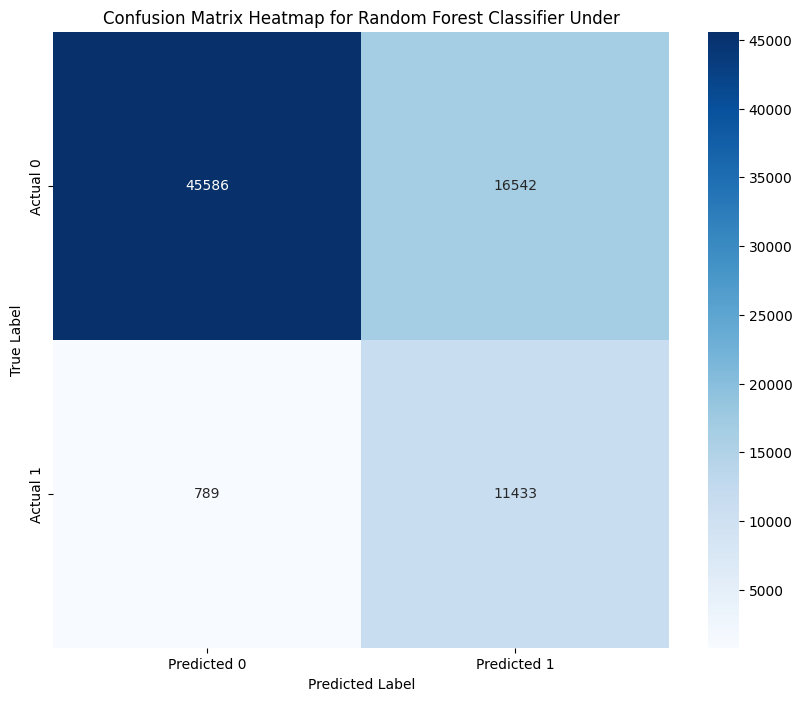


Classification Report for Random Forest Classifier Under


              precision    recall  f1-score   support

           0       0.98      0.73      0.84     62128
           1       0.41      0.94      0.57     12222

    accuracy                           0.77     74350
   macro avg       0.70      0.83      0.70     74350
weighted avg       0.89      0.77      0.80     74350



Results for Random Forest Classifier Under


Accuracy is: 0.77
ROC AUC is : 0.83
F1 Score is : 0.57

ROC Curve for Random Forest Classifier Under




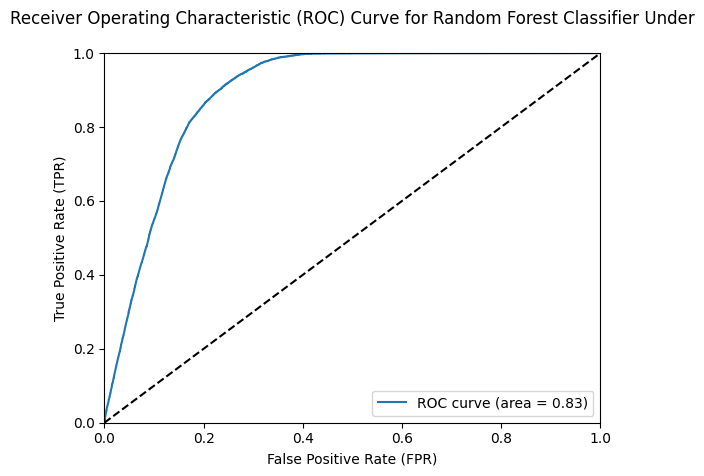

In [ ]:
# Train and Fit the model on Undersampled Data
Ranfor_Tuned.fit(Ins_Pred_Trn_undersampled, Ins_Tgt_Trn_undersampled)

# Get the best estimator
best_model_Ranfor = Ranfor_Tuned.best_estimator_

# Predict the results for the Test data
Ins_Tgt_pred = best_model_Ranfor.predict(Ins_Pred_Test)

# Find the Prediction Probability of the Test data
Ins_Tgt_pred_proba = best_model_Ranfor.predict_proba(Ins_Pred_Test)[:,1]

#Evaluate The models using the function
Evaluate_Models_Ins('Random Forest Classifier Under', Ins_Tgt_Test, Ins_Tgt_pred, Ins_Tgt_pred_proba)

#### Training Gaussian Naive Bayes Model

##### Training Gaussian Naive Bayes Model on Original Data

Fitting 5 folds for each of 7 candidates, totalling 35 fits

Confusion Matrix for Gaussian Naive Bayes

[[62080    48]
 [12186    36]]


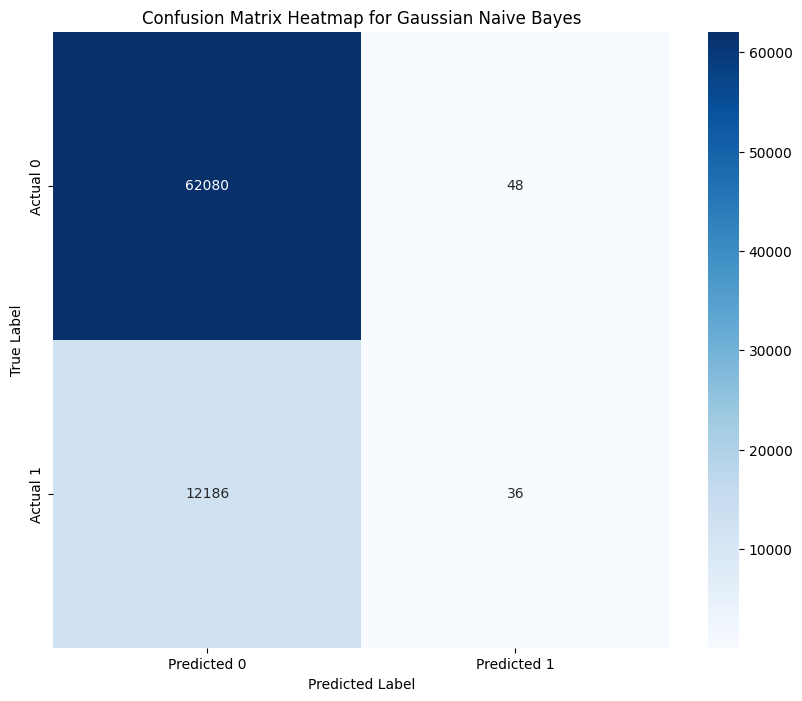


Classification Report for Gaussian Naive Bayes


              precision    recall  f1-score   support

           0       0.84      1.00      0.91     62128
           1       0.43      0.00      0.01     12222

    accuracy                           0.84     74350
   macro avg       0.63      0.50      0.46     74350
weighted avg       0.77      0.84      0.76     74350



Results for Gaussian Naive Bayes


Accuracy is: 0.84
ROC AUC is : 0.50
F1 Score is : 0.01

ROC Curve for Gaussian Naive Bayes




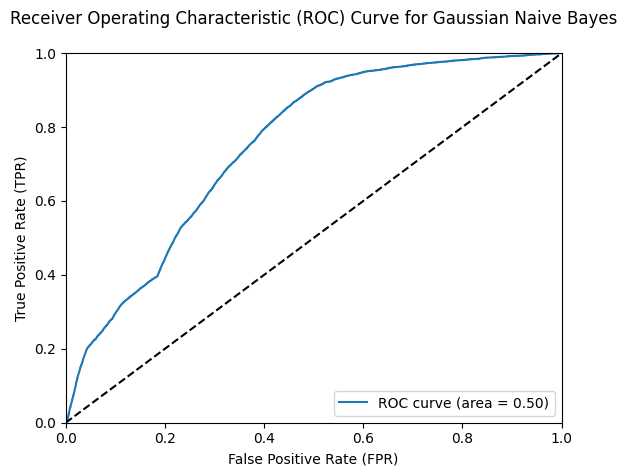

In [ ]:
# Define the parameter grid for Gaussian NB Model
param_grid_gnb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}

# Create the GaussianNB model instance
GNB_Int = GaussianNB()

# Setup the RandomizedSearchCV
GNB_Tuned = RandomizedSearchCV(
    estimator=GNB_Int,
    param_distributions=param_grid_gnb,
    n_iter=10,
    cv=5,
    verbose=2,
    random_state=3706,
    n_jobs=-1
)

# Train the model on the Original Data
GNB_Tuned.fit(Ins_Pred_Trn, Ins_Tgt_Trn)

# Get the best estimator
best_model_gnb = GNB_Tuned.best_estimator_

# Predict the response for test dataset
Ins_Tgt_pred = best_model_gnb.predict(Ins_Pred_Test)

# Find the Prediction Probability of the Test data
Ins_Tgt_pred_proba = best_model_gnb.predict_proba(Ins_Pred_Test)[:,1]

#Evaluate the model using the Function
Evaluate_Models_Ins('Gaussian Naive Bayes', Ins_Tgt_Test, Ins_Tgt_pred, Ins_Tgt_pred_proba)

##### Training Gaussian Naive Bayes Model on Oversampled Data

Fitting 5 folds for each of 7 candidates, totalling 35 fits

Confusion Matrix for Gaussian Naive Bayes Over

[[40804 21324]
 [  269 11953]]


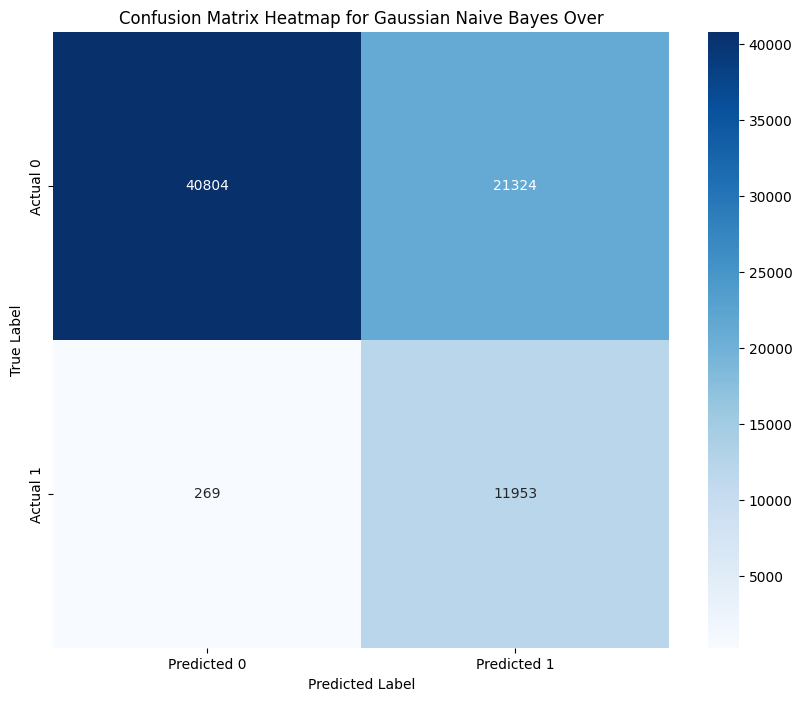


Classification Report for Gaussian Naive Bayes Over


              precision    recall  f1-score   support

           0       0.99      0.66      0.79     62128
           1       0.36      0.98      0.53     12222

    accuracy                           0.71     74350
   macro avg       0.68      0.82      0.66     74350
weighted avg       0.89      0.71      0.75     74350



Results for Gaussian Naive Bayes Over


Accuracy is: 0.71
ROC AUC is : 0.82
F1 Score is : 0.53

ROC Curve for Gaussian Naive Bayes Over




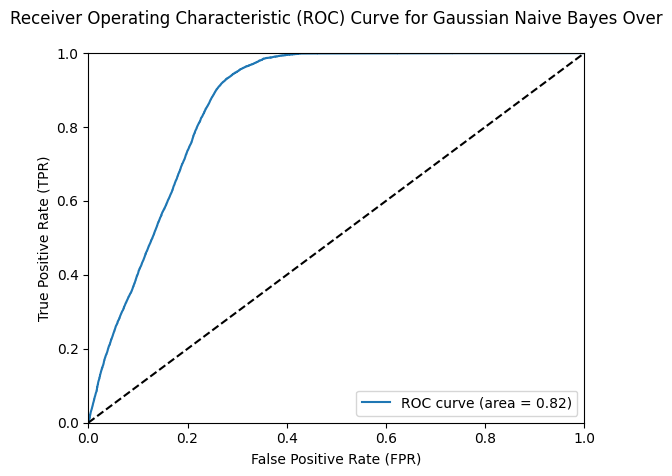

In [ ]:
# Train the model on the oversampled data
GNB_Tuned.fit(Ins_Pred_Trn_Oversampled, Ins_Tgt_Trn_oversampled)

# Get the best estimator
best_model_gnb = GNB_Tuned.best_estimator_

# Predict the response for test dataset
Ins_Tgt_pred = best_model_gnb.predict(Ins_Pred_Test)

# Find the Prediction Probability of the Test data
Ins_Tgt_pred_proba = best_model_gnb.predict_proba(Ins_Pred_Test)[:,1]

#Evaluate the model using the Function
Evaluate_Models_Ins('Gaussian Naive Bayes Over', Ins_Tgt_Test, Ins_Tgt_pred, Ins_Tgt_pred_proba)

##### Training Gaussian Naive Bayes Model on Undersampled Data

Fitting 5 folds for each of 7 candidates, totalling 35 fits

Confusion Matrix for Gaussian Naive Bayes Under

[[40301 21827]
 [  186 12036]]


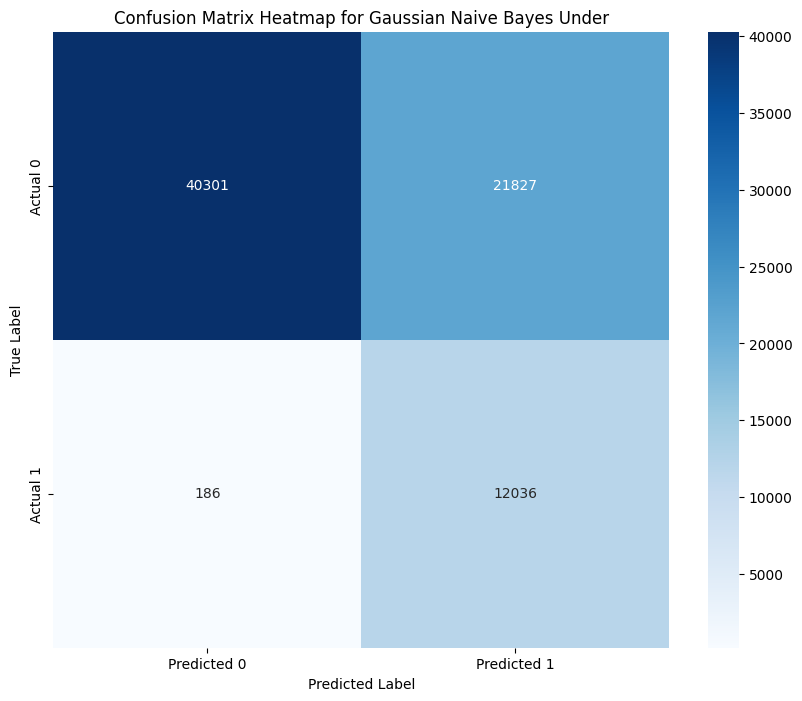


Classification Report for Gaussian Naive Bayes Under


              precision    recall  f1-score   support

           0       1.00      0.65      0.79     62128
           1       0.36      0.98      0.52     12222

    accuracy                           0.70     74350
   macro avg       0.68      0.82      0.65     74350
weighted avg       0.89      0.70      0.74     74350



Results for Gaussian Naive Bayes Under


Accuracy is: 0.70
ROC AUC is : 0.82
F1 Score is : 0.52

ROC Curve for Gaussian Naive Bayes Under




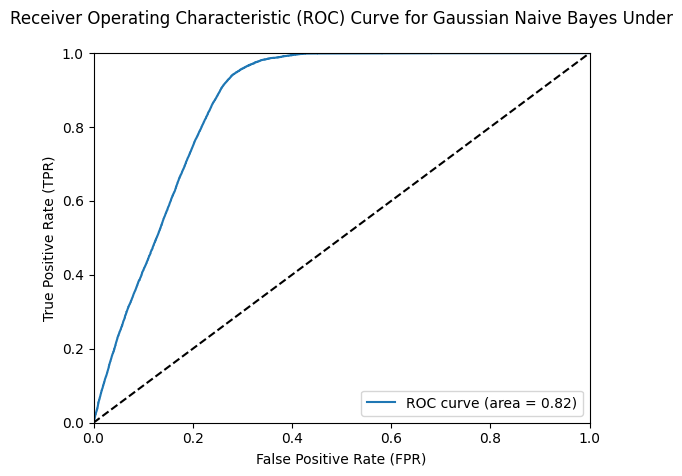

In [ ]:
# Train the model on Undersampled data
GNB_Tuned.fit(Ins_Pred_Trn_undersampled, Ins_Tgt_Trn_undersampled)

# Get the best estimator
best_model_gnb = GNB_Tuned.best_estimator_

# Predict the response for test dataset
Ins_Tgt_pred = best_model_gnb.predict(Ins_Pred_Test)

# Find the Prediction Probability of the Test data
Ins_Tgt_pred_proba = best_model_gnb.predict_proba(Ins_Pred_Test)[:,1]

#Evaluate the model using the Function
Evaluate_Models_Ins('Gaussian Naive Bayes Under', Ins_Tgt_Test, Ins_Tgt_pred, Ins_Tgt_pred_proba)

### Result Summary and Visualization

In [ ]:
# Create a dictionary to store evaluation metrics for each model
prediction_dict = {
    'Accuracy': Acc_Val_Ins,
    'ROC AUC': roc_auc_Val_Ins,
    'F1 Score': f1_score_val_Ins  }

# Convert the dictionary into a DataFrame for easier visualization
Results_DF_Ins = pd.DataFrame(prediction_dict, index=Models_Ch_Ins)

# Set the display precision for floating-point numbers
pd.set_option('display.precision', 2)

# Display the DataFrame with the evaluation metrics
Results_DF_Ins


,Accuracy,ROC AUC,F1 Score
Logistic Regression,0.84,0.50,1.61e-02
Logistic Regression Over,0.71,0.80,5.12e-01
Logistic Regression Under,0.70,0.82,5.22e-01
Decision Tree Classifier,0.84,0.66,4.50e-01
Decision Tree Classifier Over,0.79,0.83,5.80e-01
Decision Tree Classifier Under,0.78,0.83,5.77e-01
Random Forest Classifier,0.84,0.53,1.06e-01
Random Forest Classifier Over,0.79,0.83,5.81e-01
Random Forest Classifier Under,0.77,0.83,5.69e-01
Gaussian Naive Bayes,0.84,0.50,5.85e-03


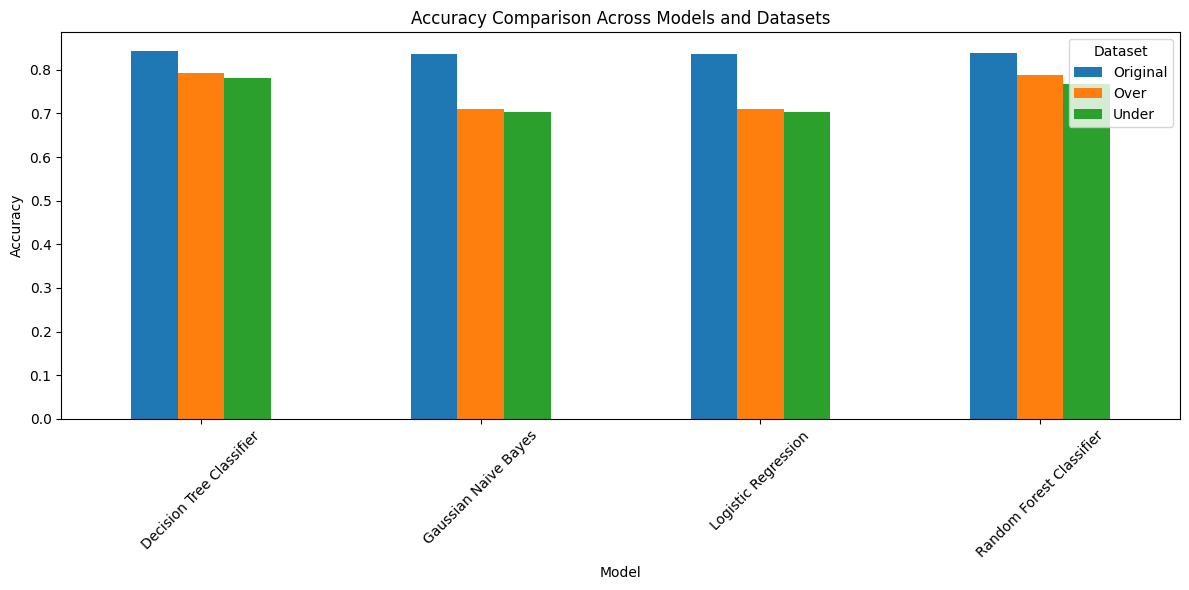

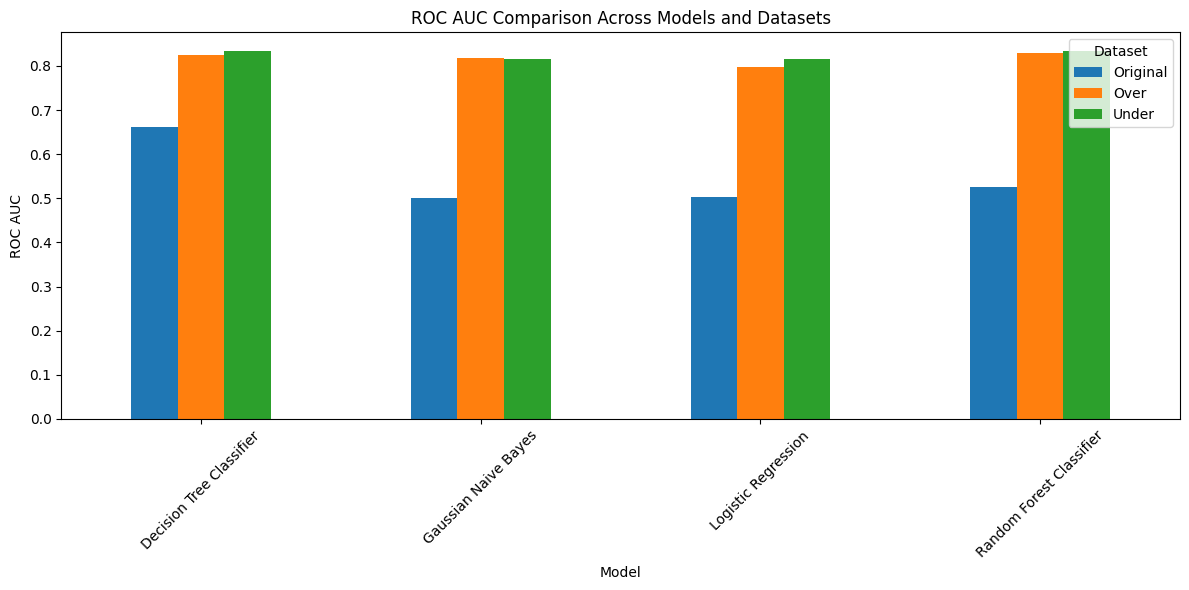

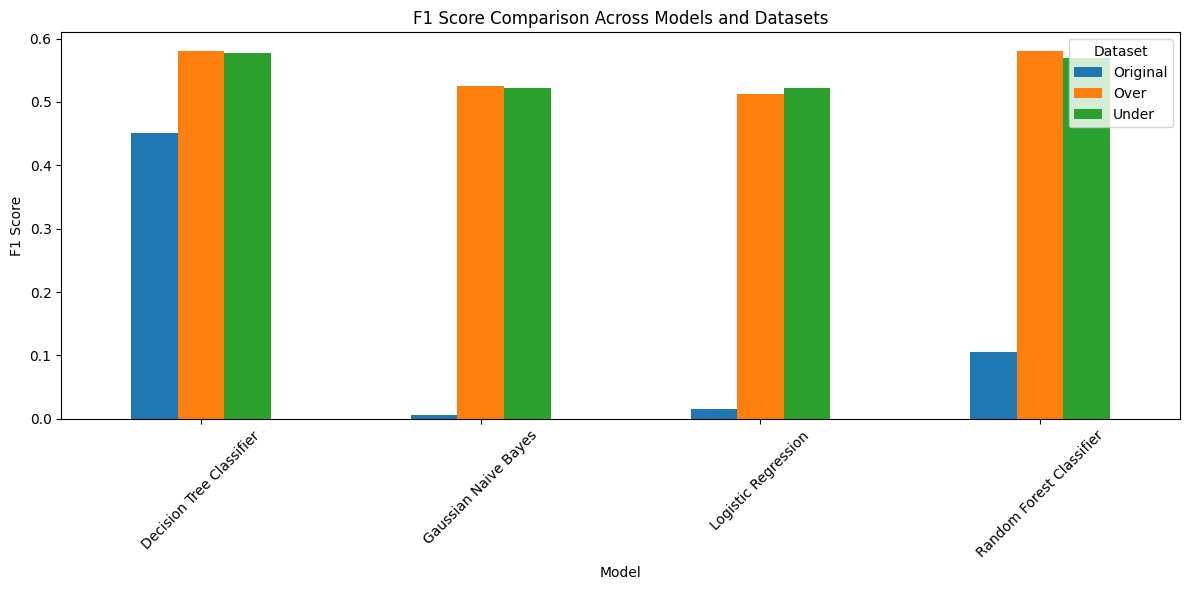

In [ ]:
# Reset and fix the index
Results_DF_Ins['Model_Dataset'] = Results_DF_Ins.index
Results_DF_Ins['Model'] = Results_DF_Ins['Model_Dataset'].str.extract(r'(.*?)( Over| Under|$)')[0]
Results_DF_Ins['Dataset'] = Results_DF_Ins['Model_Dataset'].str.extract(r'( Over| Under|$)')[0].str.strip().replace({'': 'Original'})

# Drop duplicates and pivot
Results_DF_Ins = Results_DF_Ins.drop_duplicates(subset=['Model', 'Dataset'])

# Metrics to plot
metrics = ['Accuracy', 'ROC AUC', 'F1 Score']

# Datasets in consistent order
datasets = ['Original', 'Over', 'Under']

# Plot grouped bar plots for each metric
for metric in metrics:
    plt.figure(figsize=(12, 6))
    grouped = Results_DF_Ins.pivot(index='Model', columns='Dataset', values=metric)
    grouped = grouped[datasets]  # Ensure consistent column order
    grouped.plot(kind='bar', ax=plt.gca())
    plt.title(f"{metric} Comparison Across Models and Datasets")
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.legend(title='Dataset', loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
